## 16-6. 프로젝트 - Movielens 영화 SBR

이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import pandas as pd
import tensorflow
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(pd.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


```
1) 데이터 확인
$ ls -l ~/data

2) 프로젝트 폴더 생성
$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
$ ln -s ~/data/* ~/aiffel/yoochoose/data
```

In [2]:
# ! ls -l ~/data
# ! mkdir -p ~/aiffel/yoochoose
# ! ln -s ~/data/* ~/aiffel/yoochoose/data

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
# 전체 userid수와 아이템수
data["UserId"].nunique(), data["ItemId"].nunique()

(6040, 3706)

- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [5]:
# 시간변환
data["Time"] = pd.to_datetime(data["Timestamp"], unit = "s")
data["Time"]

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

### Step 1. 데이터의 전처리

---------------------------------

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

> UserId = SessionId로 그냥 간다

In [6]:
data["SessionId"] = data["UserId"]
data

,UserId,ItemId,Rating,Timestamp,Time,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
24,1,2340,3,978300103,2000-12-31 22:01:43,1
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,6040
999988,6040,1921,4,997454464,2001-08-10 14:41:04,6040
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,6040
1000167,6040,161,3,997454486,2001-08-10 14:41:26,6040


__Session Length__  
너무 많은 평가를 매긴 경우 이상치일 수 있다. 

In [7]:
# UserId Lenght
session_length = data.groupby(["SessionId"]).size()  # 유저 아이디 숫자, 즉 각 유저아이디별로 활동한 사건 수
session_length

SessionId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

최소 값 :  20
최대 값 :  2314
평균 값 :  165.5975165562914
중앙 값 :  96.0
누적백분율 90% 값 :  400.0


<AxesSubplot:>

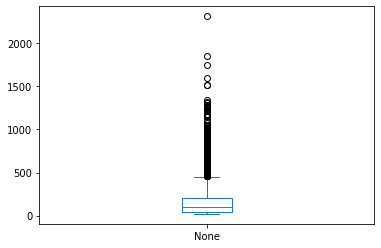

In [8]:
# 기본적인 통계값 확인
print("최소 값 : ",session_length.min())
print("최대 값 : ",session_length.max())
print("평균 값 : ",session_length.mean())
print("중앙 값 : ",session_length.median())
print("누적백분율 90% 값 : ",session_length.quantile(0.90))

session_length.plot(kind = "box")

In [9]:
session_length.groupby(session_length).size()

20      86
21      91
22      77
23      81
24      81
        ..
1521     1
1595     1
1743     1
1850     1
2314     1
Length: 743, dtype: int64

In [10]:
length_count = session_length.groupby(session_length).size()  # 유저의 활동수를 기준으로 묶는다.
length_percent_cumsum = length_count.cumsum() / length_count.sum()  # 각 활동이 얼마나 많은 활동이었는지 누적 분포로 확인한다. 
length_percent_cumsum_90 = length_percent_cumsum[length_percent_cumsum < 0.9]  # 클릭수가 너무 많은 상위 90% 이상은 제거한다.
length_percent_cumsum_90

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
395    0.897682
396    0.897848
397    0.898344
398    0.899007
399    0.899834
Length: 376, dtype: float64

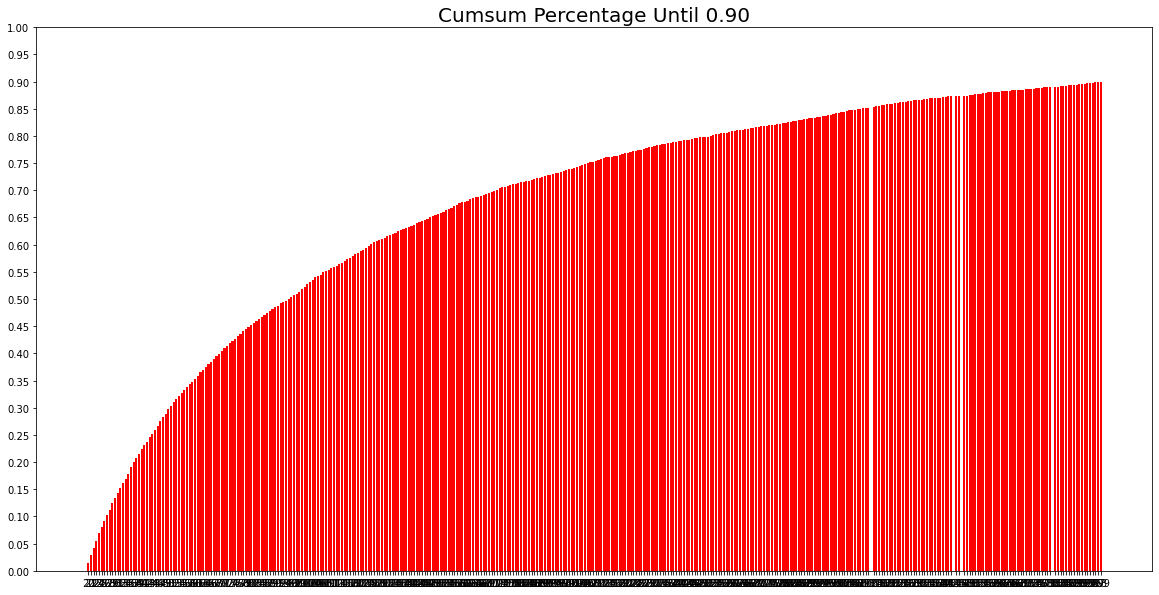

In [11]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_90.index,
        height=length_percent_cumsum_90, color='red')
plt.xticks(length_percent_cumsum_90.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.90', size=20)
# plt.xticks(rotation = 45)
plt.show()

__Session Time__  

최신 트렌드를 반영하기 위해 최근 1년간 평가한 session을 활용

In [12]:
# 가장 오래된 노드와 가장 최신 노드
oldest,latest = data["Time"].min(), data["Time"].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [13]:
# month_ago = latest - dt.timedelta(730)
# data_recent = data[data["Time"] > month_ago]
# data_recent

__Data Cleaning__

In [14]:
data.shape

(1000209, 6)

In [15]:
# Rating 이 4 미만인 행은 삭제
data = data[data["Rating"] >= 4]
data

,UserId,ItemId,Rating,Timestamp,Time,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
36,1,1836,5,978300172,2000-12-31 22:02:52,1
...,...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27,6040
999923,6040,232,5,997454398,2001-08-10 14:39:58,6040
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,6040
999988,6040,1921,4,997454464,2001-08-10 14:41:04,6040


In [16]:
def cleanse_recursive(data : pd.DataFrame, shortest, least_eval) -> pd.DataFrame :
    while True : 
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_eval)
        after_len = len(data)
        if before_len == after_len:
            break
    return data
        
        
def cleanse_short_session(data : pd.DataFrame, shortest) : 
    session_len = data.groupby("SessionId").size()
    session_use = session_len[session_len >= shortest].index  # 가장 짧은 세션 이상의 session의 index 저장
    data = data[data["SessionId"].isin(session_use)]
    return data

def cleanse_unpopular_item(data : pd.DataFrame, least_eval) : 
    item_popular = data.groupby(["ItemId"]).size()
    item_use = item_popular[item_popular >= least_eval].index
    data = data[data["ItemId"].isin(item_use)]
    return data

In [17]:
# itemid 출현 빈토 최소값
data.groupby(["ItemId"]).size().min()

1

In [18]:
# 평가 수가 2개 이하인 세션은 삭제, 평가 횟수가 5회 미만인 영화도 삭제
data = cleanse_recursive(data, shortest = 2, least_eval = 5)
data

,UserId,ItemId,Rating,Timestamp,Time,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
36,1,1836,5,978300172,2000-12-31 22:02:52,1
...,...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27,6040
999923,6040,232,5,997454398,2001-08-10 14:39:58,6040
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,6040
999988,6040,1921,4,997454464,2001-08-10 14:41:04,6040


__Train / Valid / Test split__

In [19]:
def split_by_date(data : pd.DataFrame, n_days: int):
    final_time = data["Time"].max()
    session_last_time = data.groupby(["SessionId"])["Time"].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    
    before_date = data[data["SessionId"].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date    

In [20]:
data.sort_values(by = "Time", ascending = True, inplace = True)

In [21]:
data["date"] = data["Time"].dt.date

In [22]:
data

,UserId,ItemId,Rating,Timestamp,Time,SessionId,date
1000138,6040,858,4,956703932,2000-04-25 23:05:32,6040,2000-04-25
999873,6040,593,5,956703954,2000-04-25 23:05:54,6040,2000-04-25
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,6040,2000-04-25
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,6040,2000-04-25
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,6040,2000-04-25
...,...,...,...,...,...,...,...
825497,4958,2453,4,1046454260,2003-02-28 17:44:20,4958,2003-02-28
825526,4958,3489,4,1046454320,2003-02-28 17:45:20,4958,2003-02-28
825438,4958,1407,5,1046454443,2003-02-28 17:47:23,4958,2003-02-28
825724,4958,3264,4,1046454548,2003-02-28 17:49:08,4958,2003-02-28


In [23]:
import datetime as dt
train, test = split_by_date(data, n_days = 180)
train, val = split_by_date(train, n_days = 180)

In [24]:
train.shape, val.shape, test.shape

((472369, 7), (29662, 7), (72353, 7))

In [25]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [26]:
stats_info(train, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 472369
	 Sessions: 5572
	 Items: 3125
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-04 22:46:11

* valid Set Stats Info
	 Events: 29662
	 Sessions: 152
	 Items: 2597
	 First Time : 2000-04-30 06:38:59
	 Last Time : 2002-09-01 00:14:13

* test Set Stats Info
	 Events: 72353
	 Sessions: 313
	 Items: 2933
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [27]:
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [28]:
save_path = data_path / 'processed'  # Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

--------------------------------------

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [29]:
class SessionDataset:

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId
        # 유니크 아이디 개수만큼 배열 생성
            
    def get_click_offsets(self):
        """
        세션에 수 누적값 구하기
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()  # 이게 무슨말일까?
        return offsets

In [30]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Timestamp,Time,SessionId,date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,6040,2000-04-25,0
999873,6040,593,5,956703954,2000-04-25 23:05:54,6040,2000-04-25,1
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,6040,2000-04-25,2
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,6040,2000-04-25,3
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,6040,2000-04-25,4
999967,6040,3111,5,956704056,2000-04-25 23:07:36,6040,2000-04-25,5
999868,6040,573,4,956704056,2000-04-25 23:07:36,6040,2000-04-25,6
999920,6040,213,5,956704056,2000-04-25 23:07:36,6040,2000-04-25,7
999980,6040,3505,4,956704056,2000-04-25 23:07:36,6040,2000-04-25,8
999971,6040,2503,5,956704191,2000-04-25 23:09:51,6040,2000-04-25,9


In [31]:
# sessionId to idx
train_dataset.session_idx

array([   0,    1,    2, ..., 5569, 5570, 5571])

In [32]:
# 이게 무슨 의미일까?
# train_dataset.click_offsets
train_dataset.df.groupby("SessionId").size()

SessionId
1        45
2        73
3        37
4        18
5        82
       ... 
6036    399
6037    120
6038     13
6039     90
6040    213
Length: 5572, dtype: int64

In [33]:
# 1번 session에 2번 session을 더해서 점점 누적
# 그래서 그게 무슨 의미가 있을까?
train_dataset.df.groupby("SessionId").size().cumsum()[1:]  # 심지어 2번 인덱스 부터 시작

SessionId
2          118
3          155
4          173
5          255
6          305
         ...  
6036    471933
6037    472053
6038    472066
6039    472156
6040    472369
Length: 5571, dtype: int64

In [34]:
# 0 부터 시작하는 sessioid 발생건수의 누적합 배열이 생성된다.
train_dataset.click_offsets

array([     0,     45,    118, ..., 472066, 472156, 472369], dtype=int32)

__SessionDataLoader__

In [35]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [36]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Timestamp,Time,SessionId,date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,6040,2000-04-25,0
999873,6040,593,5,956703954,2000-04-25 23:05:54,6040,2000-04-25,1
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,6040,2000-04-25,2
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,6040,2000-04-25,3
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,6040,2000-04-25,4
999967,6040,3111,5,956704056,2000-04-25 23:07:36,6040,2000-04-25,5
999868,6040,573,4,956704056,2000-04-25 23:07:36,6040,2000-04-25,6
999920,6040,213,5,956704056,2000-04-25 23:07:36,6040,2000-04-25,7
999980,6040,3505,4,956704056,2000-04-25 23:07:36,6040,2000-04-25,8
999971,6040,2503,5,956704191,2000-04-25 23:09:51,6040,2000-04-25,9


In [37]:
iter_ex = iter(train_data_loader)

In [38]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  45 116 138]
Label Item Idx are :       [  1  46 117 139]
Previous Masked Input Idx are []


### Step 3. 모델 구성

------------------------------------

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

__Evaluation Metric__

In [39]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

__Model Architecture__

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [41]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [42]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [43]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    476550    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3125)               159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

-----------------------------

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [44]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

__model_1__  

train, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

In [45]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

Evaluation:  29%|██▉       | 67/230 [00:38<01:34,  1.73it/s]


	 - Recall@20 epoch 1: 0.097248
	 - MRR@20    epoch 1: 0.021110



Evaluation:  29%|██▉       | 67/230 [00:36<01:29,  1.82it/s]


	 - Recall@20 epoch 2: 0.171409
	 - MRR@20    epoch 2: 0.040135



Evaluation:  29%|██▉       | 67/230 [00:36<01:28,  1.84it/s]


	 - Recall@20 epoch 3: 0.195546
	 - MRR@20    epoch 3: 0.046533



Evaluation:  29%|██▉       | 67/230 [00:35<01:27,  1.87it/s]


	 - Recall@20 epoch 4: 0.211754
	 - MRR@20    epoch 4: 0.049868



Evaluation:  29%|██▉       | 67/230 [00:36<01:28,  1.85it/s]


	 - Recall@20 epoch 5: 0.219100
	 - MRR@20    epoch 5: 0.052680



Evaluation:  29%|██▉       | 67/230 [00:35<01:26,  1.88it/s]


	 - Recall@20 epoch 6: 0.225047
	 - MRR@20    epoch 6: 0.053814



Evaluation:  29%|██▉       | 67/230 [00:35<01:26,  1.88it/s]


	 - Recall@20 epoch 7: 0.227845
	 - MRR@20    epoch 7: 0.054480



Evaluation:  29%|██▉       | 67/230 [00:36<01:27,  1.86it/s]


	 - Recall@20 epoch 8: 0.228195
	 - MRR@20    epoch 8: 0.055596



Evaluation:  29%|██▉       | 67/230 [00:35<01:25,  1.90it/s]


	 - Recall@20 epoch 9: 0.226096
	 - MRR@20    epoch 9: 0.056607



Evaluation:  29%|██▉       | 67/230 [00:35<01:25,  1.90it/s]

	 - Recall@20 epoch 10: 0.223881
	 - MRR@20    epoch 10: 0.056026



> val 인덱싱에서 문제가 있었는데 날짜를 늘리니까 갑자기 됐다.
아무래도 길이가 너무 짧아서 문제가 있었던거 같다. 

### Step 5. 모델 테스트

-------------------------

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [46]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [47]:
test_model(model, args, test)

Evaluation:  68%|██████▊   | 383/562 [03:22<01:34,  1.89it/s]

	 - Recall@20: 0.223340
	 - MRR@20: 0.054573



### Step 6. 하이퍼 파라미터 수정

__model_2__

train, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=40

In [48]:
args = Args(train, val, test, batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=20, k=40)
model_2 = create_model(args)
train_model(model_2, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  968100    
_________________________________________________________________
dropout_1 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_1 (Dense)              (128, 3125)               315625    
Total params: 1,283,725
Trainable params: 1,283,725
Non-trainable params: 0
_________________________________________________________________


Evaluation:  29%|██▉       | 67/230 [01:03<02:35,  1.05it/s]


	 - Recall@40 epoch 1: 0.227379
	 - MRR@40    epoch 1: 0.035723



Evaluation:  29%|██▉       | 67/230 [00:59<02:24,  1.13it/s]


	 - Recall@40 epoch 2: 0.302006
	 - MRR@40    epoch 2: 0.051507



Evaluation:  29%|██▉       | 67/230 [00:59<02:25,  1.12it/s]


	 - Recall@40 epoch 3: 0.323461
	 - MRR@40    epoch 3: 0.057051



Evaluation:  29%|██▉       | 67/230 [00:58<02:22,  1.14it/s]


	 - Recall@40 epoch 4: 0.333372
	 - MRR@40    epoch 4: 0.059967



Evaluation:  29%|██▉       | 67/230 [00:59<02:24,  1.13it/s]


	 - Recall@40 epoch 5: 0.337920
	 - MRR@40    epoch 5: 0.061166



Evaluation:  29%|██▉       | 67/230 [00:59<02:23,  1.14it/s]


	 - Recall@40 epoch 6: 0.334538
	 - MRR@40    epoch 6: 0.062194



Evaluation:  29%|██▉       | 67/230 [00:57<02:20,  1.16it/s]


	 - Recall@40 epoch 7: 0.333605
	 - MRR@40    epoch 7: 0.063174



Evaluation:  29%|██▉       | 67/230 [00:57<02:20,  1.16it/s]


	 - Recall@40 epoch 8: 0.331040
	 - MRR@40    epoch 8: 0.062816



Evaluation:  29%|██▉       | 67/230 [00:57<02:20,  1.16it/s]


	 - Recall@40 epoch 9: 0.328825
	 - MRR@40    epoch 9: 0.062251



Evaluation:  29%|██▉       | 67/230 [00:57<02:20,  1.16it/s]


	 - Recall@40 epoch 10: 0.325326
	 - MRR@40    epoch 10: 0.062674



Evaluation:  29%|██▉       | 67/230 [00:57<02:20,  1.16it/s]


	 - Recall@40 epoch 11: 0.323694
	 - MRR@40    epoch 11: 0.062343



Evaluation:  29%|██▉       | 67/230 [00:58<02:21,  1.15it/s]


	 - Recall@40 epoch 12: 0.322178
	 - MRR@40    epoch 12: 0.061193



Evaluation:  29%|██▉       | 67/230 [00:59<02:24,  1.13it/s]


	 - Recall@40 epoch 13: 0.318214
	 - MRR@40    epoch 13: 0.061666



Evaluation:  29%|██▉       | 67/230 [00:58<02:21,  1.15it/s]


	 - Recall@40 epoch 14: 0.317631
	 - MRR@40    epoch 14: 0.061114



Evaluation:  29%|██▉       | 67/230 [00:58<02:22,  1.14it/s]


	 - Recall@40 epoch 15: 0.315065
	 - MRR@40    epoch 15: 0.060575



Evaluation:  29%|██▉       | 67/230 [00:58<02:22,  1.15it/s]


	 - Recall@40 epoch 16: 0.314366
	 - MRR@40    epoch 16: 0.060423



Evaluation:  29%|██▉       | 67/230 [00:58<02:21,  1.15it/s]


	 - Recall@40 epoch 17: 0.312850
	 - MRR@40    epoch 17: 0.060967



Evaluation:  29%|██▉       | 67/230 [00:58<02:21,  1.15it/s]


	 - Recall@40 epoch 18: 0.310868
	 - MRR@40    epoch 18: 0.060632



Evaluation:  29%|██▉       | 67/230 [00:57<02:20,  1.16it/s]


	 - Recall@40 epoch 19: 0.310984
	 - MRR@40    epoch 19: 0.060271



Evaluation:  29%|██▉       | 67/230 [00:58<02:21,  1.15it/s]

	 - Recall@40 epoch 20: 0.308652
	 - MRR@40    epoch 20: 0.059203



In [49]:
test_model(model_2, args, test)

Evaluation:  68%|██████▊   | 383/562 [03:20<01:33,  1.91it/s]

	 - Recall@40: 0.205348
	 - MRR@40: 0.052541



## 회고
> Session을 최선을 다해서 나누어 봤는데 결론은 userid를 기반을 만드는것이 가장 recall지표가 높았다. 
결론적으로 중앙값이나, 유저별로 특정한 시그널을 기준으로 session을 구분하는것은 어렵기도 하거니와 그냥 유저별로 일정텀이 넘어가면 session을 나누는 방법보다 특별히 효율적일것 같지 않았다. 
물론 내가 생각한 것보다 정교하게 session을 나누는 방법이 있을수도 있지만 내가 내린 결론은 movielens data는 영화데이터이고 심지어 영화를 보고 바로 평가하는 데이터가 아니라 이미 본 영화에 대해서 평가하는 시점만 다른 데이터라 지금 내가 보고싶은 영화를 추천해주는 세션 베이스 추천의 의미가 많이 퇴색될것으로 판단되었다. 
추후에 MF 방식을 활용해 다시 실험해보고싶다